In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

from gensim.models import Word2Vec
from tqdm import tqdm


In [6]:
from pathlib import Path

BASE_CORPUS_DIR = Path("../task-01/assets/annotated-corpus")

def tokens_from_tsv(tsv_path: Path, col: int = 1, drop_punct: bool = False):
    tokens = []
    with tsv_path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue 
            parts = line.split("\t")
            if len(parts) < 3:
                parts = line.split()
            if len(parts) <= col:
                continue
            tok = parts[col].strip()
            if not tok:
                continue
            if drop_punct:
                if not any(ch.isalnum() for ch in tok):
                    continue
            tokens.append(tok)
    return tokens


In [7]:
def load_split_docs(split: str, col: int = 1, drop_punct: bool = False):
    split_dir = BASE_CORPUS_DIR / split
    doc_ids, docs, labels = [], [], []
    
    for label_dir in sorted(split_dir.iterdir()):
        if not label_dir.is_dir():
            continue
        label = label_dir.name  # '1','2','3','4'
        for tsv_path in sorted(label_dir.glob("*.tsv")):
            toks = tokens_from_tsv(tsv_path, col=col, drop_punct=drop_punct)
            if not toks:
                continue
            doc_ids.append(tsv_path.stem)
            docs.append(toks)
            labels.append(label)
    
    return doc_ids, docs, labels

train_ids, train_docs, train_labels = load_split_docs("train", col=1, drop_punct=False)
test_ids,  test_docs,  test_labels  = load_split_docs("test",  col=1, drop_punct=False)

len(train_docs), len(test_docs), train_ids[:3], train_labels[:3]



(120000, 7600, ['000492', '000493', '000494'], ['1', '1', '1'])

In [8]:
from gensim.models import Word2Vec

EMBEDDING_DIM = 100

w2v_model = Word2Vec(
    sentences=train_docs,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=3,
    workers=4,
    sg=1,
    epochs=10,
)

list(w2v_model.wv.key_to_index.keys())[:10]


['.', 'the', ',', 'to', 'a', 'of', 'in', ';', '-', 'and']

In [28]:
list(w2v_model.wv.key_to_index.keys())[:100]

['.',
 'the',
 ',',
 'to',
 'a',
 'of',
 'in',
 ';',
 '-',
 'and',
 'on',
 'for',
 '#',
 '39',
 'it',
 '(',
 ')',
 's',
 'that',
 '\\',
 'with',
 '&',
 'as',
 'at',
 'is',
 'new',
 'by',
 'said',
 'reuter',
 ':',
 'has',
 'from',
 'an',
 'ap',
 'his',
 'will',
 'after',
 'be',
 'was',
 'gt',
 'lt',
 '"',
 'us',
 'have',
 'year',
 'over',
 'quot',
 '$',
 'their',
 '/',
 'up',
 'are',
 'compani',
 'but',
 'more',
 'first',
 'two',
 'say',
 'he',
 'u',
 'report',
 'this',
 'game',
 'world',
 'monday',
 'wednesday',
 'tuesday',
 'thursday',
 'out',
 'oil',
 'one',
 "'",
 '2',
 'not',
 'against',
 'stock',
 'price',
 'inc',
 'friday',
 'win',
 'week',
 'into',
 'state',
 'plan',
 'b',
 'unit',
 'last',
 '=',
 'about',
 ';/',
 '1',
 'than',
 'million',
 'they',
 'york',
 'kill',
 'presid',
 'yesterday',
 'who',
 'secur']

In [10]:
def get_word_vector(word: str, model: Word2Vec, dim: int):
    if word in model.wv:
        return model.wv[word]
    else:
        return np.zeros(dim, dtype="float32")

def cosine_distance(vec1: np.ndarray, vec2: np.ndarray):
    num = np.dot(vec1, vec2)
    den = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    if den == 0:
        return 1.0
    return 1.0 - num / den


In [30]:
def demo_word_groups(anchor, similar_words, same_domain_words, different_words, model, dim):
    def dist(w):
        v1 = get_word_vector(anchor, model, dim)
        v2 = get_word_vector(w, model, dim)
        return cosine_distance(v1, v2)
    
    print(f"Якорное слово: {anchor}\n")
    for name, group in [
        ("Похожие по смыслу", similar_words),
        ("Из той же предметной области", same_domain_words),
        ("Далёкие по смыслу", different_words),
    ]:
        print(name + ":")
        for w in group:
            print(f"  {w:<20} dist = {dist(w):.4f}")
        print()


demo_word_groups(
    anchor="doctor",
    similar_words=["physician", "surgeon", "medic"],
    same_domain_words=["patient", "clinic", "treatment", "symptom"],
    different_words=["car", "computer", "lawyer", "teacher", "banana"],
    model=w2v_model,
    dim=EMBEDDING_DIM
)

Якорное слово: doctor

Похожие по смыслу:
  physician            dist = 0.3648
  surgeon              dist = 0.4679
  medic                dist = 0.3172

Из той же предметной области:
  patient              dist = 0.2686
  clinic               dist = 0.4248
  treatment            dist = 0.4065
  symptom              dist = 0.4247

Далёкие по смыслу:
  car                  dist = 0.6501
  computer             dist = 0.6801
  lawyer               dist = 0.5378
  teacher              dist = 0.5624
  banana               dist = 0.7645



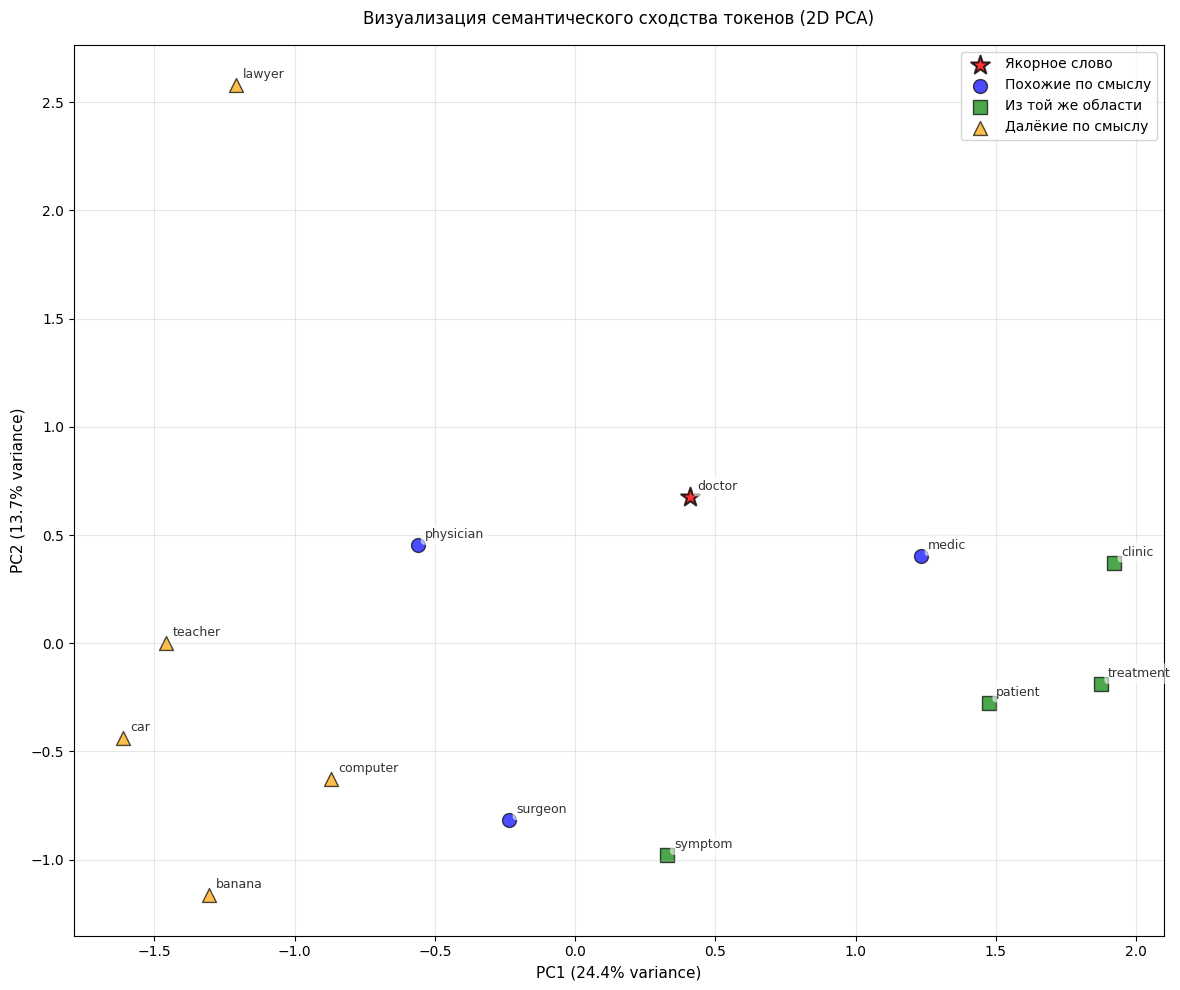


Объяснённая дисперсия компонентами PCA:
  PC1: 24.43%
  PC2: 13.66%
  Суммарно: 38.09%


In [32]:
def visualize_word_groups_2d(
    anchor, 
    similar_words, 
    same_domain_words, 
    different_words, 
    model, 
    dim,
    use_3d=False
):

    all_words = [anchor] + similar_words + same_domain_words + different_words
    
    vectors = []
    valid_words = []
    
    for word in all_words:
        vec = get_word_vector(word, model, dim)
        if np.linalg.norm(vec) > 0:
            vectors.append(vec)
            valid_words.append(word)
        else:
            print(f"Предупреждение: слово '{word}' не найдено в модели, пропускаем")
    
    if len(vectors) < 2:
        print("Ошибка: недостаточно слов для визуализации")
        return
    
    vectors = np.array(vectors)
    
    # Применяем PCA для сокращения размерности
    target_dim = 3 if use_3d else 2
    pca = PCA(n_components=target_dim)
    reduced_vectors = pca.fit_transform(vectors)
    
    # Создаём метки для групп
    labels = []
    colors = []
    for word in valid_words:
        if word == anchor:
            labels.append(f"{word} (anchor)")
            colors.append('red')
        elif word in similar_words:
            labels.append(word)
            colors.append('blue')
        elif word in same_domain_words:
            labels.append(word)
            colors.append('green')
        elif word in different_words:
            labels.append(word)
            colors.append('orange')
    
    if use_3d:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        anchor_idx = [i for i, w in enumerate(valid_words) if w == anchor]
        similar_idx = [i for i, w in enumerate(valid_words) if w in similar_words]
        domain_idx = [i for i, w in enumerate(valid_words) if w in same_domain_words]
        different_idx = [i for i, w in enumerate(valid_words) if w in different_words]
        
        if anchor_idx:
            ax.scatter(reduced_vectors[anchor_idx, 0], 
                      reduced_vectors[anchor_idx, 1], 
                      reduced_vectors[anchor_idx, 2],
                      c='red', s=200, marker='*', label='Якорное слово', alpha=0.8)
        if similar_idx:
            ax.scatter(reduced_vectors[similar_idx, 0], 
                      reduced_vectors[similar_idx, 1], 
                      reduced_vectors[similar_idx, 2],
                      c='blue', s=100, marker='o', label='Похожие по смыслу', alpha=0.7)
        if domain_idx:
            ax.scatter(reduced_vectors[domain_idx, 0], 
                      reduced_vectors[domain_idx, 1], 
                      reduced_vectors[domain_idx, 2],
                      c='green', s=100, marker='s', label='Из той же области', alpha=0.7)
        if different_idx:
            ax.scatter(reduced_vectors[different_idx, 0], 
                      reduced_vectors[different_idx, 1], 
                      reduced_vectors[different_idx, 2],
                      c='orange', s=100, marker='^', label='Далёкие по смыслу', alpha=0.7)
        
        # Добавляем текстовые метки
        for i, (word, label) in enumerate(zip(valid_words, labels)):
            ax.text(reduced_vectors[i, 0], 
                   reduced_vectors[i, 1], 
                   reduced_vectors[i, 2],
                   f'  {word}', fontsize=9, alpha=0.8)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=10)
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=10)
        ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)', fontsize=10)
        ax.set_title('Визуализация семантического сходства токенов (3D PCA)', fontsize=12, pad=20)
        ax.legend(loc='upper left')
        
    else:
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Разбиваем по группам для легенды
        anchor_idx = [i for i, w in enumerate(valid_words) if w == anchor]
        similar_idx = [i for i, w in enumerate(valid_words) if w in similar_words]
        domain_idx = [i for i, w in enumerate(valid_words) if w in same_domain_words]
        different_idx = [i for i, w in enumerate(valid_words) if w in different_words]
        
        if anchor_idx:
            ax.scatter(reduced_vectors[anchor_idx, 0], 
                      reduced_vectors[anchor_idx, 1],
                      c='red', s=200, marker='*', label='Якорное слово', alpha=0.8, edgecolors='black', linewidths=1.5)
        if similar_idx:
            ax.scatter(reduced_vectors[similar_idx, 0], 
                      reduced_vectors[similar_idx, 1],
                      c='blue', s=100, marker='o', label='Похожие по смыслу', alpha=0.7, edgecolors='black', linewidths=1)
        if domain_idx:
            ax.scatter(reduced_vectors[domain_idx, 0], 
                      reduced_vectors[domain_idx, 1],
                      c='green', s=100, marker='s', label='Из той же области', alpha=0.7, edgecolors='black', linewidths=1)
        if different_idx:
            ax.scatter(reduced_vectors[different_idx, 0], 
                      reduced_vectors[different_idx, 1],
                      c='orange', s=100, marker='^', label='Далёкие по смыслу', alpha=0.7, edgecolors='black', linewidths=1)
        
        # Добавляем текстовые метки
        for i, word in enumerate(valid_words):
            ax.annotate(word, 
                       (reduced_vectors[i, 0], reduced_vectors[i, 1]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, alpha=0.8, 
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.6, edgecolor='none'))
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
        ax.set_title('Визуализация семантического сходства токенов (2D PCA)', fontsize=12, pad=15)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Выводим информацию о объяснённой дисперсии
    print(f"\nОбъяснённая дисперсия компонентами PCA:")
    for i, var_ratio in enumerate(pca.explained_variance_ratio_, 1):
        print(f"  PC{i}: {var_ratio:.2%}")
    print(f"  Суммарно: {sum(pca.explained_variance_ratio_):.2%}")


visualize_word_groups_2d(
    anchor="doctor",
    similar_words=["physician", "surgeon", "medic"],
    same_domain_words=["patient", "clinic", "treatment", "symptom"],
    different_words=["car", "computer", "lawyer", "teacher", "banana"],
    model=w2v_model,
    dim=EMBEDDING_DIM,
    use_3d=False 
)



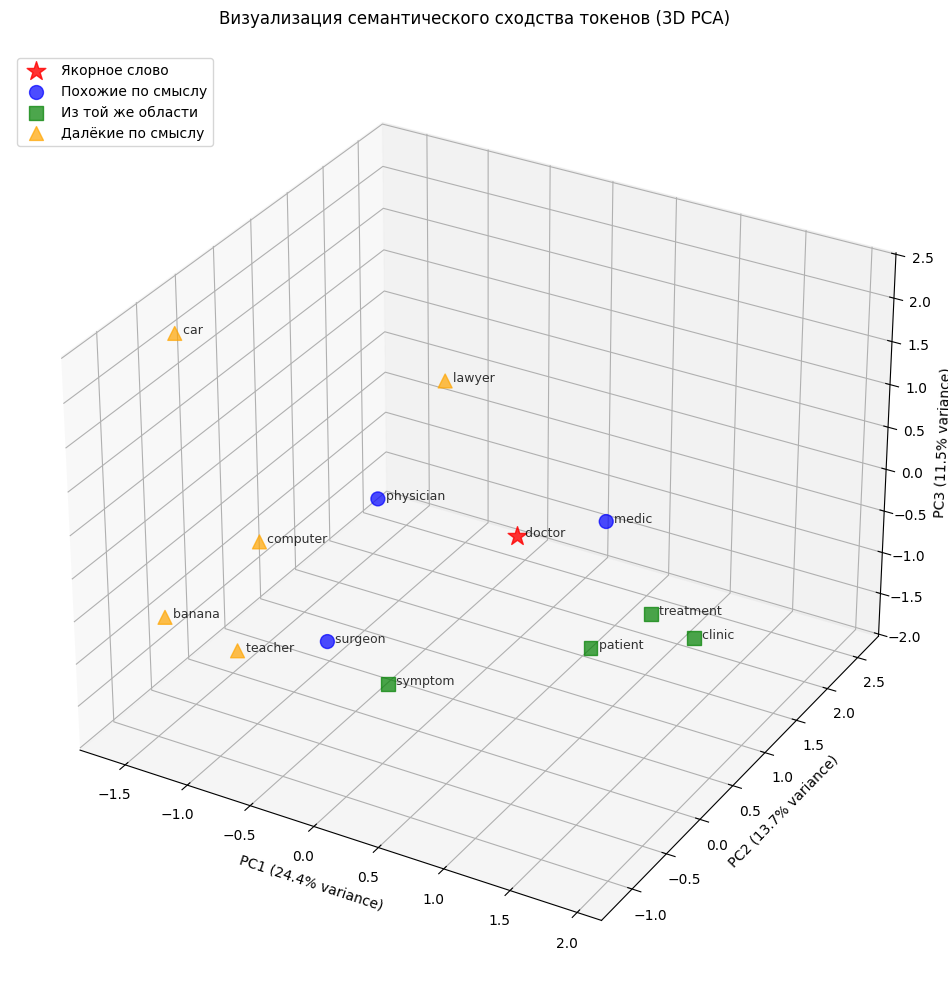


Объяснённая дисперсия компонентами PCA:
  PC1: 24.43%
  PC2: 13.66%
  PC3: 11.52%
  Суммарно: 49.62%


In [33]:

visualize_word_groups_2d(
    anchor="doctor",
    similar_words=["physician", "surgeon", "medic"],
    same_domain_words=["patient", "clinic", "treatment", "symptom"],
    different_words=["car", "computer", "lawyer", "teacher", "banana"],
    model=w2v_model,
    dim=EMBEDDING_DIM,
    use_3d=True 
)

In [16]:
import pandas as pd


TRAIN_PATH = "../task-01/data/train.csv"
TEST_PATH  = "../task-01/data/test.csv"

train_df = pd.read_csv(
    TRAIN_PATH,
    sep=",",
    header=None,
    names=["label", "title", "text"],
)

test_df = pd.read_csv(
    TEST_PATH,
    sep=",",
    header=None,
    names=["title", "text"],
)

train_df.head(), train_df.columns



(   label                                              title  \
 0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
 1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
 2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
 3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
 4      3  Oil prices soar to all-time record, posing new...   
 
                                                 text  
 0  Reuters - Short-sellers, Wall Street's dwindli...  
 1  Reuters - Private investment firm Carlyle Grou...  
 2  Reuters - Soaring crude prices plus worries\ab...  
 3  Reuters - Authorities have halted oil export\f...  
 4  AFP - Tearaway world oil prices, toppling reco...  ,
 Index(['label', 'title', 'text'], dtype='object'))

In [25]:
ABBREVIATIONS = [
    "Mr", "Ms", "Mrs", "Dr", "Prof", "Inc", "Ltd", "Jr", "Sr",
    "U.S", "U.K", "St", "Univ"
]
def protect_abbreviations(text: str):
    for abbr in ABBREVIATIONS:
        text = re.sub(
            rf"\b{abbr}\.",
            abbr.replace(".", "<DOT>") + "<DOT>",
            text
        )
    return text

sentence_end_re = re.compile(r'(?<=[.!?])\s+')

def restore_abbreviations(text: str):
    return text.replace("<DOT>", ".")

def split_to_sentences(text: str):
    if not isinstance(text, str):
        text = str(text)

    text = re.sub(r'\s+', ' ', text.strip())
    if not text:
        return []

    protected = protect_abbreviations(text)

    parts = sentence_end_re.split(protected)

    parts = [restore_abbreviations(p) for p in parts]

    return [p.strip() for p in parts if p.strip()]


token_pattern = re.compile(
    r"""
    (?:\+?\d[\d\-\(\)\s]{7,}\d)                 # телефоны, напр. +7-901-000-00-00
    | (?:[\w\.-]+@[\w\.-]+\.\w+)                # email, напр. abc@xyz.com
    | (?:[:;=8][\-^']?[)DdpP(/\\])              # смайлики :) ;-) :D
    | (?:\d+(?:[.,]\d+)*)                       # числа
    | (?:[A-Za-zА-Яа-яЁё]+(?:[-'][A-Za-zА-Яа-яЁё]+)*)  # слова с дефисами/апострофами
    | (?:[^\s])                                 # одиночный не-пробельный символ
    """,
    re.VERBOSE
)


def tokenize(text: str):
    if not isinstance(text, str):
        text = str(text)
    return [m.group(0) for m in token_pattern.finditer(text)]

In [26]:
def sentence_to_vector(sentence: str, model: Word2Vec, dim: int):
    tokens = tokenize(sentence)
    if not tokens:
        return np.zeros(dim, dtype="float32")
    vecs = [get_word_vector(t, model, dim) for t in tokens]
    if not vecs:
        return np.zeros(dim, dtype="float32")
    return np.mean(vecs, axis=0)

def text_to_document_vector(text: str, model: Word2Vec, dim: int):
    sentences = split_to_sentences(text)
    sent_vecs = []
    for sent in sentences:
        v = sentence_to_vector(sent, model, dim)
        if np.linalg.norm(v) > 0:
            sent_vecs.append(v)
    if not sent_vecs:
        return np.zeros(dim, dtype="float32")
    return np.mean(sent_vecs, axis=0)

doc_vec = text_to_document_vector(train_df["text"].iloc[0], w2v_model, EMBEDDING_DIM)
doc_vec.shape, doc_vec[:10]


((100,),
 array([-0.04279441,  0.14493191,  0.0367752 ,  0.05473366, -0.04199129,
        -0.0456581 ,  0.04768786,  0.24999072, -0.07689396, -0.13266253],
       dtype=float32))

In [27]:
embeddings = []
doc_ids = []

for idx, text in tqdm(enumerate(test_df["text"]), total=len(test_df), desc="Векторизация теста"):
    vec = text_to_document_vector(text, w2v_model, EMBEDDING_DIM)
    embeddings.append(vec)
    doc_ids.append(str(idx))

embeddings = np.vstack(embeddings)

result_df = pd.DataFrame(embeddings)
result_df.insert(0, "doc_id", doc_ids)

OUTPUT_PATH = "test_embeddings_w2v.tsv"
result_df.to_csv(OUTPUT_PATH, sep="\t", index=False, header=False)



Векторизация теста: 100%|██████████| 7600/7600 [00:01<00:00, 3953.50it/s]
